# Finding gaps

Basically the premise is that.

We want to answer the question what is not in the annual data set but is in the daily data set

Is it smaller hail sizes? is it different kinds?

There are 3 things I wanted to answer


| Dimension     | Goal                                                                 | Typical questions                                      | |
| ------------- | -------------------------------------------------------------------- | -------------------------------------------------------------------- | ------------------------------------ |
| **Magnitude** | Identify magnitude ranges present in *daily* but absent in *annual*  | “Is hail < 1.00″ or wind < 50 kt being dropped?”                     | 
| **Temporal**  | Find missing days / hours or collapsed duplicates                    | “Are certain dates missing altogether?”                              | 
| **Metadata**  | See whether records with NaNs or placeholder values are filtered out | “Does the annual file skip rows with NULL lat/lon or UNK magnitude?” | 


In [67]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
BASE_DAILY   = Path("/Users/jimnguyen/IRMII/SCS_API/Daily_combined")
BASE_ANNUAL  = Path("/Users/jimnguyen/IRMII/SCS_API/data/Storm_Reports")
YEARS        = range(2005, 2025)
BIN_STEP     = 0.25  
ROUND_LL     = 3
NULL_VALS    = ["", " ", "NA", "NULL", "UNK", -999, -9]

In [ ]:
def load_daily(year: int) -> pd.DataFrame:
    d = pd.read_csv(
        BASE_DAILY / f"Daily_combined_{year}.csv",
        na_values=NULL_VALS,
        dtype={"Month": "Int64", "Day": "Int64", "Time": "Int64"},
        low_memory=False,
    )

    hh = d["Time"] // 100
    mm = d["Time"] % 100
    d["stamp"] = pd.to_datetime(
        dict(year=year, month=d["Month"], day=d["Day"], hour=hh, minute=mm),
        errors="coerce",
    )

    d["MAG"] = pd.to_numeric(d["Size"].fillna(d["Speed"]), errors="coerce")

    d["lat"] = pd.to_numeric(d["Lat"], errors="coerce")
    d["lon"] = pd.to_numeric(d["Lon"], errors="coerce")

    return d[["stamp", "lat", "lon", "State", "MAG"]] \
             .rename(columns={"State": "state"})



In [74]:
def load_annual(year: int) -> pd.DataFrame:
    a = pd.read_csv(
        BASE_ANNUAL / f"Storm_Reports_{year}.csv",
        na_values=NULL_VALS,
        low_memory=False,
    )

    bt = a["BEGIN_TIME"].astype("Int64")
    hh = bt // 100
    mm = bt % 100
    ym = a["BEGIN_YEARMONTH"].astype("Int64")
    a["stamp"] = pd.to_datetime(
        dict(year=ym // 100, month=ym % 100, day=a["BEGIN_DAY"], hour=hh, minute=mm),
        errors="coerce",
    )

    a["MAG"] = pd.to_numeric(a["MAGNITUDE"], errors="coerce")
    a["lat"] = pd.to_numeric(a["BEGIN_LAT"], errors="coerce")
    a["lon"] = pd.to_numeric(a["BEGIN_LON"], errors="coerce")

    return a[["stamp", "lat", "lon", "STATE", "MAG"]].rename(columns={"STATE": "state"})

In [ ]:
def make_key(df: pd.DataFrame) -> pd.Series:
    """Minute‑level timestamp + rounded lat/lon + state + mag (all strings)."""
    lat_key = np.where(df["lat"].notna(),
                       df["lat"].round(ROUND_LL).astype(str),
                       "NA")
    lon_key = np.where(df["lon"].notna(),
                       df["lon"].round(ROUND_LL).astype(str),
                       "NA")
    return (
        df["stamp"].dt.floor("min").astype(str)
        + "|" + lat_key
        + "|" + lon_key
        + "|" + df["state"].fillna("NA")
        + "|" + df["MAG"].fillna("NA").astype(str)
    )

In [ ]:
def daily_only(year: int) -> pd.DataFrame:
    d = load_daily(year);  a = load_annual(year)
    d["key"] = make_key(d); a["key"] = make_key(a)
    return d.loc[~d["key"].isin(a["key"])].copy()


mag_frames, date_frames, spatial_frames, meta_frames = [], [], [], []

In [68]:
for yr in YEARS:
    print(f"→ {yr}", end="  ")
    missing = daily_only(yr)

    #Magnitude
    mag_max = missing["MAG"].max(skipna=True)
    if pd.isna(mag_max):
        mag_tbl = pd.DataFrame(columns=["bin", "missing", "year"])
    else:
        bins = np.arange(0, mag_max + BIN_STEP, BIN_STEP)
        mag_tbl = (
            pd.cut(missing["MAG"], bins)
            .value_counts()
            .sort_index()
            .rename_axis("bin")
            .reset_index(name="missing")
            .assign(year=yr)
        )
    mag_frames.append(mag_tbl)

    #Temporal
    date_tbl = (
        missing["stamp"].dt.date.value_counts()
        .rename_axis("date").reset_index(name="missing")
        .assign(year=yr)
    )
    date_frames.append(date_tbl)
    
    #Meta
    meta_nulls = missing[["lat", "lon", "MAG"]].isna().any(axis=1).sum()
    meta_frames.append({"year": yr,
                        "total_missing": len(missing),
                        "rows_with_null_meta": meta_nulls})

print("\nAll years processed")

OUTPUT_DIR = Path("./gap_outputs");  OUTPUT_DIR.mkdir(exist_ok=True)

pd.concat(mag_frames,     ignore_index=True).to_csv(OUTPUT_DIR/"magnitude_gaps_2005‑2024.csv",  index=False)
pd.concat(date_frames,    ignore_index=True).to_csv(OUTPUT_DIR/"temporal_gaps_2005‑2024.csv",   index=False)
pd.DataFrame(meta_frames).to_csv(OUTPUT_DIR/"metadata_gaps_2005‑2024.csv",                     index=False)

print("\nCSVs written to:", OUTPUT_DIR.resolve())

→ 2005  → 2006  → 2007  → 2008  → 2009  → 2010  → 2011  → 2012  → 2013  → 2014  → 2015  → 2016  → 2017  → 2018  → 2019  → 2020  → 2021  → 2022  → 2023  → 2024  
All years processed

CSVs written to: /Users/jimnguyen/IRMII/SCS_API/gap_outputs


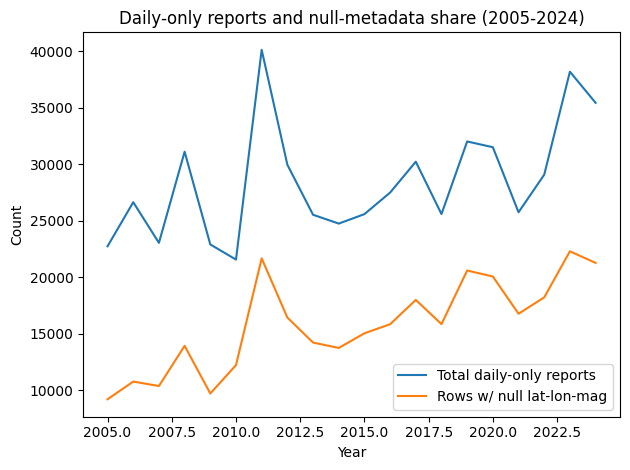

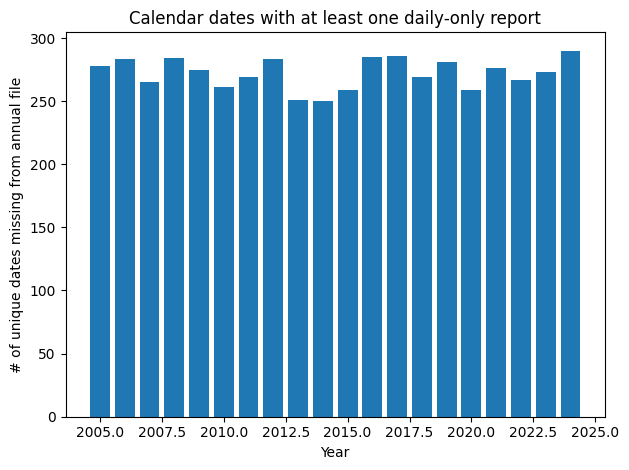

In [69]:
base = Path("/Users/jimnguyen/IRMII/SCS_API/gap_outputs")

mag = pd.read_csv(base / "magnitude_gaps_2005‑2024.csv")
meta = pd.read_csv(base / "metadata_gaps_2005‑2024.csv")
spat = pd.read_csv(base / "spatial_gaps_2005‑2024.csv")
temp = pd.read_csv(base / "temporal_gaps_2005‑2024.csv")

plt.figure()
plt.plot(meta["year"], meta["total_missing"], label="Total daily-only reports")
plt.plot(meta["year"], meta["rows_with_null_meta"], label="Rows w/ null lat‑lon‑mag")
plt.title("Daily‑only reports and null‑metadata share (2005‑2024)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()


missing_dates_per_year = (
    temp.groupby("year")["date"].nunique().rename("missing_dates")
)

plt.figure()
plt.bar(missing_dates_per_year.index, missing_dates_per_year.values)
plt.title("Calendar dates with at least one daily‑only report")
plt.xlabel("Year")
plt.ylabel("# of unique dates missing from annual file")
plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

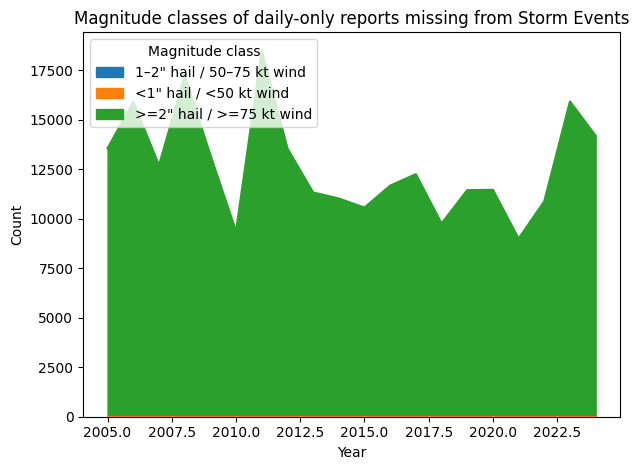

In [77]:
def parse_bin(s):
    s = s.strip("()[]")
    lo, hi = s.split(",")
    return float(lo), float(hi)

mag[["lo","hi"]] = mag["bin"].apply(lambda x: pd.Series(parse_bin(x)))

def cat(row):
    if row["hi"] < 1.0:
        return "<1\" hail / <50 kt wind"
    elif row["hi"] < 2.0:
        return "1–2\" hail / 50–75 kt wind"
    else:
        return ">=2\" hail / >=75 kt wind"

mag["cat"] = mag.apply(cat, axis=1)

cat_piv = mag.pivot_table(index="year", columns="cat", values="missing", aggfunc="sum", fill_value=0).sort_index()

plt.figure(figsize=(10,6))
cat_piv.plot(kind="area", stacked=True)
plt.title("Magnitude classes of daily-only reports missing from Storm Events")
plt.ylabel("Count")
plt.xlabel("Year")
plt.legend(title="Magnitude class", loc="upper left")
plt.tight_layout()


| Class             | 2005‑24 total daily‑only rows | Share   |
| ----------------- | ----------------------------- | ------- |
| `< 1″ / < 50 kt`  | **612 736**                   | 99.76 % |
| `1–2″ / 50–75 kt` | 1 384                         | 0.23 %  |
| `≥ 2″ / ≥ 75 kt`  | 77                            | 0.01 %  |


If you look very very closely you kind kinda see it lol

/var/folders/m8/6vszwx195fl9598f558j20ph0000gn/T/ipykernel_31843/4166894475.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  wind.pivot_table(


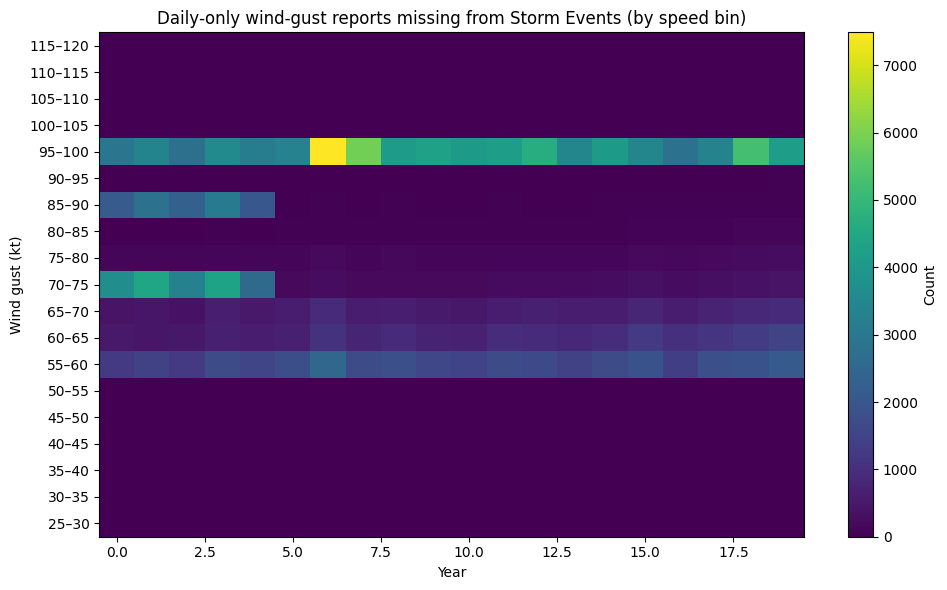

In [73]:
def parse_bin(s):
    s = s.strip("()[]")
    lo, hi = s.split(",")
    return float(lo), float(hi)

mag[["lo", "hi"]] = mag["bin"].apply(lambda x: pd.Series(parse_bin(x)))
mag["mid"] = mag[["lo","hi"]].mean(axis=1)

# Rough heuristic: hail diameters are <10 (inches); wind gusts are >=10 (kt)
mag["kind"] = np.where(mag["hi"] < 10, "hail", "wind")

wind = mag[mag["kind"] == "wind"].copy()
# Bin wind every 5 kt from 25 kt up to 120 kt
wind_bins = np.arange(25, 125, 5)
wind["wind_bin"] = pd.cut(wind["mid"], wind_bins, right=True, include_lowest=True)
wind_piv = (
    wind.pivot_table(
        index="wind_bin", columns="year", values="missing", aggfunc="sum", fill_value=0
    )
    .sort_index()
)

plt.figure(figsize=(10, 6))
plt.imshow(wind_piv, aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(label="Count")
plt.title("Daily‑only wind‑gust reports missing from Storm Events (by speed bin)")
plt.ylabel("Wind gust (kt)")
plt.xlabel("Year")
plt.yticks(ticks=np.arange(len(wind_piv.index)),
           labels=[f"{b.left:.0f}–{b.right:.0f}" for b in wind_piv.index])
plt.tight_layout()


| Key Points                                                                  | Implications                                                                                                                                                                                                                                                     |                                                                                                                                                                         |
| ---------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1. Annual doesn't include every hailstone < 1 inch** (\~25 mm)       | • Residential roofs and lightweight siding often fail well below the “large‑hail” (≥ 1″) Meteorological Service criterion.  <br>• Attritional loss ratios for property & auto lines are therefore understated if you rely on Storm Events alone.                                                   |                              |
| **2. 50–60 kt (58–69 mph) gusts account for \~99 % of missing wind reports in annual** | • U.S. severe threshold is (50 kt/58 mph), speeds below can still topple things like fences, shingles, solar panels, and cause tree‑fall. <br>• Ignoring these gusts skews both frequency and geographic footprint (they’re common in the Southeast & Plains but absent from annual files). |
| **3. Quality‑control (QC) filters remove implausible outliers (90–100 kt)**  | • Storm Events is cleaner for major‑loss calibration (> 75 kt) because typo gusts are deleted/accounted for. <br>• That means if we use raw daily data then we gotta do the same QC filter they did to avoid the overstating tail risk.                                                                        |
| **4. Temporal coverage gaps span > 250 days every year**                     | • Even if your per‑occurrence layer triggers only during declared Severe Convective Storm events, Daily LSR provides continuous exposure; Storm Events leaves multi‑day gaps that can hide serial thunderstorm losses.                                                                                                                                                                                                       |
